# Identifying safe loans with decision trees
The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use Pandas to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

In [1]:
# Import some libs

import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load LendingClub dataset
We will be using a dataset from the [LendingClub](https://www.lendingclub.com/)

In [2]:
loans_df = pandas.read_csv('/content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/data/lending-club-data.csv', low_memory=False)

In [4]:
loans_df.head(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,not_compliant,status,inactive_loans,bad_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,19850101T000000,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.07,5831.78,5000.0,861.07,0.0,0.0,0.0,20150101T000000,171.62,NaN,20150101T000000,0.0,NaN,1,0,Fully Paid,1,0,11,5,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [3]:
loans_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [ ]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans_df['safe_loans'] = loans_df['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans_df.drop(columns=['bad_loans'])

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e2b072650>]],
      dtype=object)

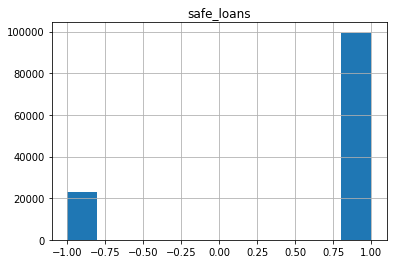

In [6]:
loans_df.hist(column='safe_loans')

## Features for the classification algorithm
In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [7]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans_df = loans_df[features + [target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook.

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [8]:
safe_loans_raw = loans_df[loans_df[target] == +1]
risky_loans_raw = loans_df[loans_df[target] == -1]
print ("Number of safe loans  : %s" % safe_loans_raw.shape[0])
print ("Number of risky loans : %s" % risky_loans_raw.shape[0])

Number of safe loans  : 99457
Number of risky loans : 23150


Now, write some code to compute below the percentage of safe and risky loans in the dataset and validate these numbers against what was given using `.show` earlier in the assignment:

In [9]:
print ("Percentage of safe loans  : {}".format(safe_loans_raw.shape[0]/loans_df.shape[0])) 
print ("Percentage of risky loans : {}".format(risky_loans_raw.shape[0]/loans_df.shape[0]))

Percentage of safe loans  : 0.8111853319957262
Percentage of risky loans : 0.18881466800427382


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed=1` so everyone gets the same results.

In [10]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = risky_loans_raw.shape[0]/safe_loans_raw.shape[0]

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [11]:
print ("Percentage of safe loans                 : {}".format(safe_loans.shape[0] / loans_data.shape[0]))
print ("Percentage of risky loans                : {}".format(risky_loans.shape[0] / loans_data.shape[0]))
print ("Total number of loans in our new dataset : {}".format(loans_data.shape[0]))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46300


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

# One-hot encoding
For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding.

In [12]:
print(loans_data.dtypes)
categorical_variables = list(loans_data.select_dtypes(include=['object']).columns)
print(categorical_variables)

grade                     object
sub_grade                 object
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
term                      object
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
safe_loans                 int64
dtype: object
['grade', 'sub_grade', 'home_ownership', 'purpose', 'term']


In [13]:
one_hot_data = pandas.get_dummies(loans_data[categorical_variables], prefix=categorical_variables)
# need to add inplace in oreder to drop columns.
loans_data.drop(columns=categorical_variables, axis=1, inplace=True)
loans_data = pandas.concat([loans_data, one_hot_data], axis=1)

## Split data into training and validation sets
We split the data into training and validation sets using an 80/20 split and specifying `seed=1` so everyone gets the same results.
**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [14]:
np.random.seed(1)

train_data, val_data = train_test_split(loans_data, test_size=0.2)

# print (train_data[target])

train_y = train_data[target].values
train_data.drop(columns=[target], inplace=True)
train_X = train_data.values

val_y = val_data[target].values
val_data.drop(columns=[target], inplace=True)
val_X = val_data.values

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Use decision tree to build a classifier
Now, let's use the built-in scikit learn decision tree learner [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to create a loan prediction model on the training data. To do this, you will need to **import sklearn, sklearn.tree, and numpy.**
<br>
Note: You will have to first convert the DataFrame into a numpy data matrix, and extract the target labels as a numpy array. See the API for more information. Make sure to set max_depth=6.

Call this model decision_tree_model.

Also train a tree using with max_depth=2. Call this model small_model.

In [15]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(max_depth=6)
small_model = DecisionTreeClassifier(max_depth=2)

In [16]:
decision_tree_model.fit(train_X, train_y)
small_model.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


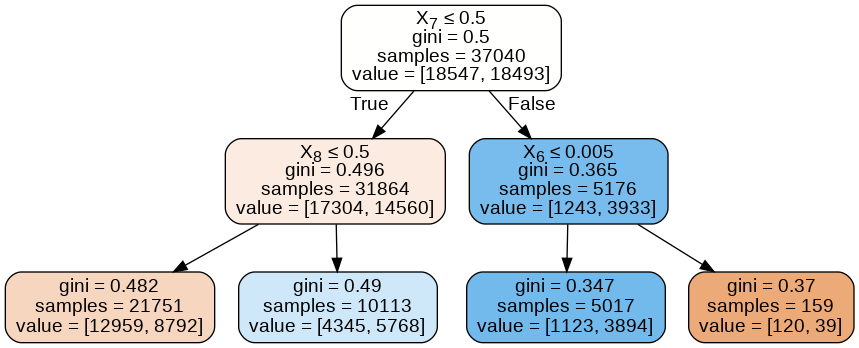

In [17]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(small_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [18]:
validation_safe_loans = val_data[val_y == 1]
validation_risky_loans = val_data[val_y == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
83265,0,11,5.92,1,1,19.2,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
89463,0,4,11.49,1,1,61.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
121355,0,11,15.90,1,1,59.7,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
39588,0,11,1.51,0,1,20.4,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## Explore label predictions
Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [20]:
predictions = decision_tree_model.predict(sample_validation_data)
print(predictions)

[ 1 -1 -1  1]


## Explore probability predictions

For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? 

In [21]:
decision_tree_model.predict_proba(sample_validation_data)

array([[0.4591029 , 0.5408971 ],
       [0.50706436, 0.49293564],
       [0.54930305, 0.45069695],
       [0.42893037, 0.57106963]])

# Evaluating accuracy of the decision tree model
Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data, validation data

In [23]:
# YOUR CODE HERE
print(decision_tree_model.score(train_X, train_y))
print(small_model.score(train_X, train_y))
print('----------')
print(decision_tree_model.score(val_X, val_y))
print(small_model.score(val_X, val_y))

0.6374460043196545
0.6139578833693304
----------
0.6317494600431965
0.6171706263498921


**Quiz Question:** What is the accuracy of `decision_tree_model` on the validation set, rounded to the nearest .01?
<br>
**Your answer:**

## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [24]:
big_model = DecisionTreeClassifier(max_depth=20)
big_model.fit(train_X, train_y)
print(big_model.score(train_X, train_y))
print(big_model.score(val_X, val_y))

0.8513498920086393
0.5799136069114471


**Checkpoint:** We should see that **big_model** has even better performance on the training set than **decision_tree_model** did on the training set.

**Quiz Question:** How does the performance of **big_model** on the validation set compare to **decision_tree_model** on the validation set? Is this a sign of overfitting?
<br>
**Your answer:**

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [25]:
predictions = decision_tree_model.predict(val_data)

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

In [38]:
false_pos_count = 0
for i in range(len(predictions)):
  if(predictions[i] == +1 and val_y[i] == -1):
    false_pos_count += 1
false_pos_count  

1423

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [39]:
false_neg_count = 0
for i in range(len(predictions)):
  if(predictions[i] == -1 and val_y[i] == 1):
    false_pos_count += 1
false_neg_count  

0

**Quiz Question:** Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?
<br>
**Your answer:**

In [40]:
cost = 10000*false_neg_count + 20000*false_pos_count
print(cost)

68200000
